In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import cv2
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [2]:
sdir= r'/content/drive/MyDrive/dataset_type_of_plants'
files=glob.glob(sdir+'/**/*.jpg', recursive=True)
print(len(files))

34142


In [3]:
max_images=200
img_size= (331,331)
filepaths=[]
labels=[]
classes= sorted(os.listdir(sdir))
class_count=len(classes)
print('Total number of classes=', class_count)
for x in classes:
  classpath=os.path.join(sdir, x)
  flist=sorted(os.listdir(classpath))
  for i,j in enumerate(flist):
    if i< max_images:
      fpath= os.path.join(classpath, j)
      filepaths.append(fpath)
      labels.append(x)
    else:
      break
print(filepaths)
print(labels)

Total number of classes= 35
['/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera0.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera1.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera10.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera100.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera101.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera102.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera103.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera104.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera105.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera106.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera107.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera108.jpg', '/content/drive/MyDrive/dataset_type_of_plants/aloevera/aloevera109.jpg', '/content/driv

In [4]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print(df)

                                              filepaths      labels
0     /content/drive/MyDrive/dataset_type_of_plants/...    aloevera
1     /content/drive/MyDrive/dataset_type_of_plants/...    aloevera
2     /content/drive/MyDrive/dataset_type_of_plants/...    aloevera
3     /content/drive/MyDrive/dataset_type_of_plants/...    aloevera
4     /content/drive/MyDrive/dataset_type_of_plants/...    aloevera
...                                                 ...         ...
6995  /content/drive/MyDrive/dataset_type_of_plants/...  watermelon
6996  /content/drive/MyDrive/dataset_type_of_plants/...  watermelon
6997  /content/drive/MyDrive/dataset_type_of_plants/...  watermelon
6998  /content/drive/MyDrive/dataset_type_of_plants/...  watermelon
6999  /content/drive/MyDrive/dataset_type_of_plants/...  watermelon

[7000 rows x 2 columns]


In [5]:
train_df, dummy_df= train_test_split(df, train_size=.8, shuffle=True, random_state=42, stratify= df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=42, stratify= dummy_df['labels'])
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df), '  test_df length: ', len(test_df))

train_df length:  5600   valid_df length:  700   test_df length:  700


In [6]:
train_datagen=ImageDataGenerator(rescale=1/255, rotation_range=40, horizontal_flip= True, shear_range=0.2,
                                 height_shift_range=0.2, width_shift_range=0.2, fill_mode='nearest', zoom_range=.2)
valid_datagen=ImageDataGenerator(rescale=1/255)
test_datagen= ImageDataGenerator(rescale=1/255)

In [7]:
train_data= train_datagen.flow_from_dataframe(train_df, x_col='filepaths',y_col='labels', target_size=img_size, 
                                             batch_size=20, class_mode='categorical', color_mode='rgb', shuffle=True)
valid_data= train_datagen.flow_from_dataframe(valid_df, x_col='filepaths',y_col='labels', target_size=img_size, 
                                             batch_size=20, class_mode='categorical', color_mode='rgb', shuffle=False)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_data= train_datagen.flow_from_dataframe(test_df, x_col='filepaths',y_col='labels', target_size=img_size, 
                                             batch_size=test_batch_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 5600 validated image filenames belonging to 35 classes.
Found 700 validated image filenames belonging to 35 classes.
Found 700 validated image filenames belonging to 35 classes.


In [8]:
img_shape=(img_size[0], img_size[1], 3)
model_name='NASNetLarge'
base_model=tf.keras.applications.NASNetLarge(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=False
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

343610240/343610240 [==============================] - 2s 0us/step


In [9]:
history=model.fit(x=train_data,  epochs=5, verbose=1,  validation_data=valid_data,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/5
280/280 [==============================] - 7708s 27s/step - loss: 9.4040 - accuracy: 0.4829 - val_loss: 7.3228 - val_accuracy: 0.6800
Epoch 2/5
280/280 [==============================] - 7609s 27s/step - loss: 6.4362 - accuracy: 0.6446 - val_loss: 5.4180 - val_accuracy: 0.6814
Epoch 3/5
280/280 [==============================] - 7707s 28s/step - loss: 4.7254 - accuracy: 0.6977 - val_loss: 4.1034 - val_accuracy: 0.7086
Epoch 4/5
280/280 [==============================] - 7648s 27s/step - loss: 3.6534 - accuracy: 0.7163 - val_loss: 3.2651 - val_accuracy: 0.7200
Epoch 5/5
280/280 [==============================] - 7711s 28s/step - loss: 2.9403 - accuracy: 0.7400 - val_loss: 2.7727 - val_accuracy: 0.7000


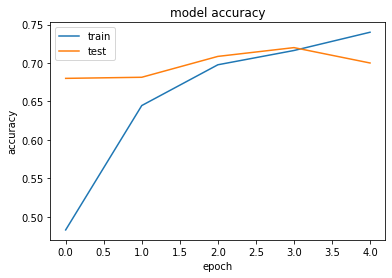

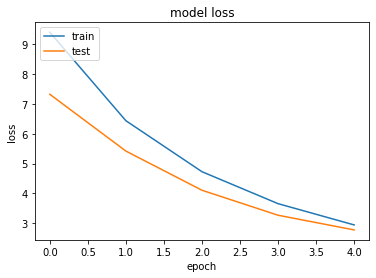

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return accuracy, precision, f1Score

10/10 [==============================] - 868s 85s/step
there were 214 errors in 700 tests for an accuracy of  69.43


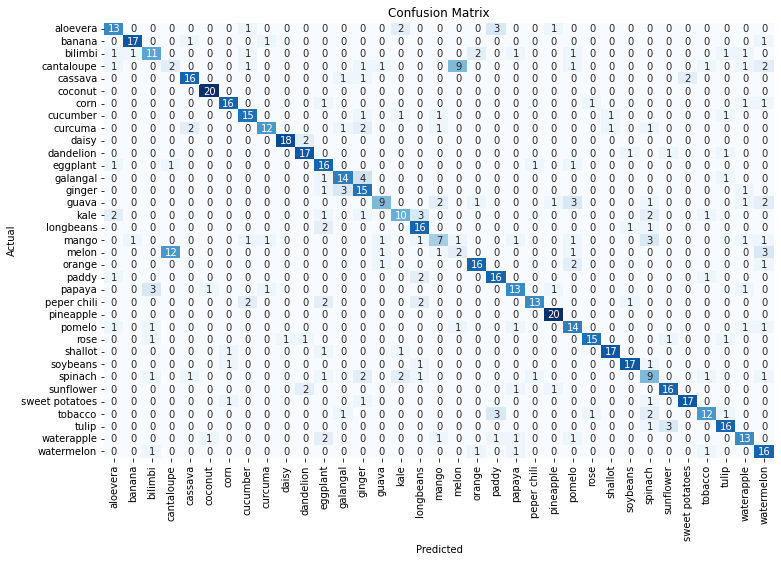

Classification Report:
----------------------
                 precision    recall  f1-score   support

      aloevera     0.6500    0.6500    0.6500        20
        banana     0.8947    0.8500    0.8718        20
       bilimbi     0.6111    0.5500    0.5789        20
    cantaloupe     0.1333    0.1000    0.1143        20
       cassava     0.8000    0.8000    0.8000        20
       coconut     0.9091    1.0000    0.9524        20
          corn     0.8421    0.8000    0.8205        20
      cucumber     0.7143    0.7500    0.7317        20
       curcuma     0.8000    0.6000    0.6857        20
         daisy     0.9474    0.9000    0.9231        20
     dandelion     0.7727    0.8500    0.8095        20
      eggplant     0.5714    0.8000    0.6667        20
      galangal     0.7000    0.7000    0.7000        20
        ginger     0.5357    0.7500    0.6250        20
         guava     0.6923    0.4500    0.5455        20
          kale     0.6250    0.5000    0.5556        20


In [12]:
def predictor(test_data):
    y_pred= []
    y_true=test_data.labels
    classes=list(test_data.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_data, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_data.labels[i]        
        if pred_index != true_index:                                           
            errors=errors + 1
            file=test_data.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_data)

10/10 [==============================] - 844s 84s/step
Accuracy  : 0.7
Precision : 0.6969155912706968
f1Score : 0.6930661971123464


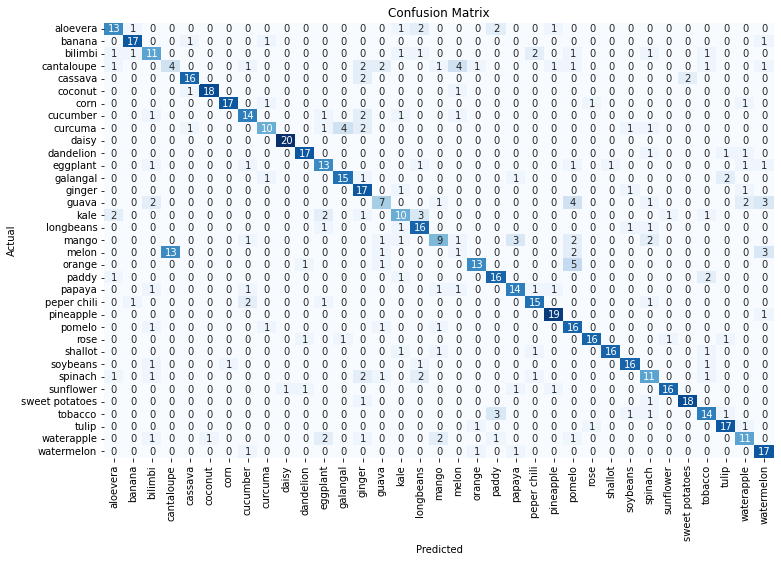

In [13]:
predictions = model.predict(test_data, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_data.labels
testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

In [14]:
  subject='plants' 
  acc=str(( 1-errors/tests) * 100)
  index=acc.rfind('.')
  acc=acc[:index + 3]
  save_id= subject + '_' + str(acc) + '.h5' 
  model_save_loc=os.path.join(r'/content/drive/MyDrive/Colab Notebooks', save_id)
  model.save(model_save_loc)
  print ('model was saved as ' , model_save_loc ) 

model was saved as  /content/drive/MyDrive/Colab Notebooks/plants_69.42.h5
